# Tides evaluation
## First check: spring tide amplitude map compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [43]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt

file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_his_hourly_0005.nc')
ds = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds.zeta.max('ocean_time')-ds.zeta.mean('ocean_time')

In [45]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_dataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

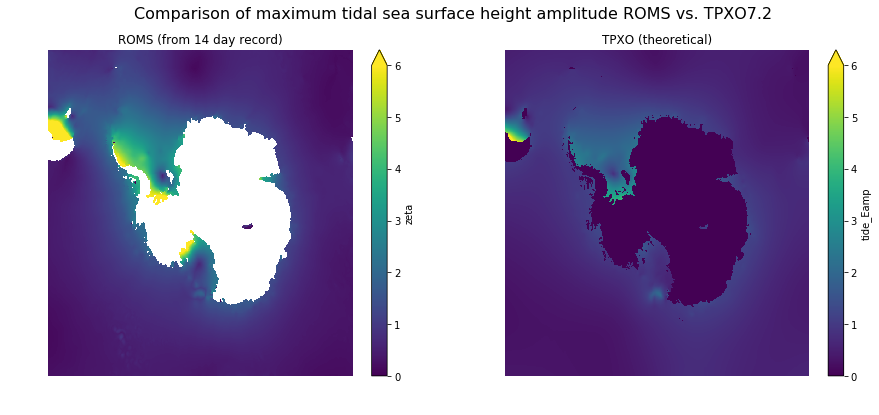

In [51]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.plot(ax=ax1,vmax=6)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=6)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()